In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=[]

env: CUDA_VISIBLE_DEVICES=[]


### Mouse USVs
Source:
- https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0199929
- https://datadryad.org/handle/10255/dryad.177144

In [2]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import IPython

In [3]:
from avgn_paper.signalprocessing import spectrogramming as sg

In [4]:
import pdb
from joblib import Parallel, delayed
n_jobs = 10
verbosity = 5

In [5]:
from tqdm.autonotebook import tqdm
from librosa.core.time_frequency import mel_frequencies
from avgn_paper.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn_paper.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn_paper.visualization.spectrogram import visualize_spec, plot_spec
from avgn_paper.utils.general import HParams
from avgn_paper.signalprocessing.filtering import butter_bandpass_filter

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### data locations

In [6]:
DSLOC = Path('/mnt/cube/Datasets/mouse_usv')
RESPLOC = DSLOC/'Respiratory_Data'

### Parse respiratory files

In [7]:
resp_files = list(RESPLOC.glob('*.txt'))

In [8]:
all_voc_df = []
for rf in tqdm(resp_files):
    with open(rf, encoding='UTF-16') as f:
        try:
            voc_df = pd.read_csv(f, delimiter='\t', header=None)
        except UnicodeError:
            continue
    voc_df.columns = ['exhalation_start', 'exhalation_end', 'USV_start', 'USV_end']
    voc_df['fileloc'] = rf
    voc_df['indv'] = rf.stem
    voc_df['voc_num'] = np.arange(len(voc_df))
    all_voc_df.append(voc_df)
voc_df = pd.concat(all_voc_df)

In [9]:
print(len(voc_df))
voc_df[:3]

52434


,exhalation_start,exhalation_end,USV_start,USV_end,fileloc,indv,voc_num
0,0.1974,0.2582,0.212610,0.244354,/mnt/cube/Datasets/mouse_usv/Respiratory_Data/...,VOC606,0
1,0.2855,0.3630,0.302709,0.330358,/mnt/cube/Datasets/mouse_usv/Respiratory_Data/...,VOC606,1
2,0.3971,0.4527,0.413286,0.444006,/mnt/cube/Datasets/mouse_usv/Respiratory_Data/...,VOC606,2


In [10]:
voc_df.indv.unique()

array(['VOC606', 'VOC591', 'VOC610', 'VOC611', 'VOC597', 'VOC615',
       'VOC612', 'VOC594', 'VOC592', 'VOC605', 'VOC602'], dtype=object)

In [11]:
np.nanmax(voc_df.USV_start.values)/60

4.454398476666667

Text(0, 0.5, 'Time (s)')

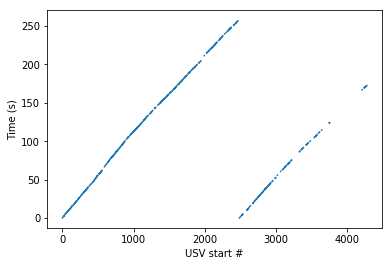

In [12]:
plt.plot(voc_df[voc_df.indv == 'VOC591'].USV_start.values)
plt.xlabel('USV start #')
plt.ylabel('Time (s)')

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


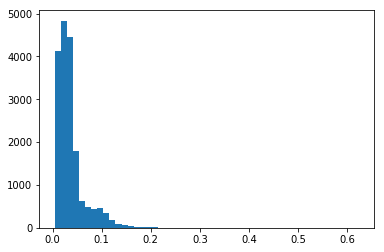

In [13]:
plt.hist(voc_df.USV_end.values - voc_df.USV_start.values, bins=50);

### Parse Wav Info

In [14]:
wav_files = list(DSLOC.expanduser().glob('*/*.WAV'))
wav_files[:3]

[PosixPath('/mnt/cube/Datasets/mouse_usv/VOC591/VOC591_Isolation_Call_CMPA_8_9_2016_14_6.04.WAV'),
 PosixPath('/mnt/cube/Datasets/mouse_usv/VOC591/VOC591_VOC571_SONG_CMPA_10_7_2016_73_22.97.WAV'),
 PosixPath('/mnt/cube/Datasets/mouse_usv/VOC591/VOC591_VOC583_SONG_CMPA_9_3_2016_39_19.17.WAV')]

In [15]:
wf_df = pd.DataFrame(
    columns=[
        "indv",
        "MaleMouse",
        "FemaleMouse",
        "SONG",
        "CMPA",
        "month",
        "day",
        "year",
        "AGE",
        "Weight",
        "wav_loc",
    ]
)
for wf in tqdm(wav_files):
    if len(wf.stem.split("_")) != 9: continue
    wf_df.loc[len(wf_df)] = [wf.parent.stem] + wf.stem.split("_") + [wf]

In [16]:
len(wf_df)

111

In [17]:
wf_df[wf_df.indv == 'VOC591'].sort_values(by=['year', 'month', 'day'])[:5]

,indv,MaleMouse,FemaleMouse,SONG,CMPA,month,day,year,AGE,Weight,wav_loc
18,VOC591,VOC591,VOC579,SONG,CMPA,10,10,2016,76,23.81,/mnt/cube/Datasets/mouse_usv/VOC591/VOC591_VOC...
30,VOC591,VOC591,VOC577,SONG,CMPA,10,13,2016,79,22.21,/mnt/cube/Datasets/mouse_usv/VOC591/VOC591_VOC...
26,VOC591,VOC591,VOC648,SONG,CMPA,10,15,2016,81,24.44,/mnt/cube/Datasets/mouse_usv/VOC591/VOC591_VOC...
28,VOC591,VOC591,VOC577,SONG,CMPA,10,17,2016,83,24.26,/mnt/cube/Datasets/mouse_usv/VOC591/VOC591_VOC...
29,VOC591,VOC591,VOC579,SONG,CMPA,10,19,2016,85,24.43,/mnt/cube/Datasets/mouse_usv/VOC591/VOC591_VOC...


In [18]:
wf_df.wav_loc.values

array([PosixPath('/mnt/cube/Datasets/mouse_usv/VOC591/VOC591_Isolation_Call_CMPA_8_9_2016_14_6.04.WAV'),
       PosixPath('/mnt/cube/Datasets/mouse_usv/VOC591/VOC591_VOC571_SONG_CMPA_10_7_2016_73_22.97.WAV'),
       PosixPath('/mnt/cube/Datasets/mouse_usv/VOC591/VOC591_VOC583_SONG_CMPA_9_3_2016_39_19.17.WAV'),
       PosixPath('/mnt/cube/Datasets/mouse_usv/VOC591/VOC591_Isolation_Call_CMPA_7_30_2016_4_1.93.WAV'),
       PosixPath('/mnt/cube/Datasets/mouse_usv/VOC591/VOC591_VOC575_SONG_CMPA_10_3_2016_69_23.85.WAV'),
       PosixPath('/mnt/cube/Datasets/mouse_usv/VOC591/VOC591_Isolation_Call_CMPA_8_2_2016_7_3.03.WAV'),
       PosixPath('/mnt/cube/Datasets/mouse_usv/VOC591/VOC591_VOC576_SONG_CMPA_10_5_2016_71_21.26.WAV'),
       PosixPath('/mnt/cube/Datasets/mouse_usv/VOC591/VOC591_Isolation_Call_CMPA_8_1_2016_6_2.65.WAV'),
       PosixPath('/mnt/cube/Datasets/mouse_usv/VOC591/VOC591_VOC579_SONG_CMPA_9_20_2016_56_22.48.WAV'),
       PosixPath('/mnt/cube/Datasets/mouse_usv/VOC591/VOC591_VO

In [19]:
np.unique(wf_df.MaleMouse.values)

array(['VOC591', 'VOC592', 'VOC594'], dtype=object)

In [20]:
np.unique(wf_df.SONG.values)

array(['Call', 'SONG'], dtype=object)

In [91]:
rate, data = load_wav(wf_df.iloc[1].wav_loc)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [92]:
len(data)/rate

184.15616

In [93]:
audio = butter_bandpass_filter(data, lowcut = 30000, highcut=120000, fs=rate, order=4) / 32768

In [94]:
np.max(audio)

0.013719929179026931

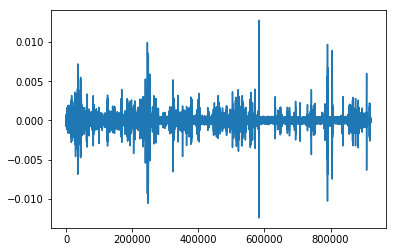

In [95]:
plt.plot(audio[::50])

In [96]:
import noisereduce as nr

In [97]:
# select section of data that is noise
noisy_part = audio[rate*1:rate*10]

In [98]:
??nr

In [99]:
# perform noise reduction
reduced_noise = nr.reduce_noise(audio_clip=audio, noise_clip=noisy_part, verbose=False)

In [100]:
len(audio)

46039040

In [101]:
len(reduced_noise)

46039040

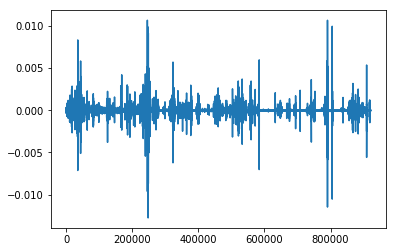

In [102]:
plt.plot(reduced_noise[::50])

In [106]:
win_length_ms = 10
hop_length_ms = 2
print(win_length_ms / 1000 * rate)
print(hop_length_ms / 1000 * rate)

hparams = HParams(
    # spectrogramming
    win_length=int(rate / 1000 * win_length_ms),
    n_fft=4096,
    hop_length=int(rate / 1000 * hop_length_ms),
    ref_level_db=20,
    min_level_db=-80,
    preemphasis=0.97,
    # mel scaling
    num_mel_bins=128,
    mel_lower_edge_hertz=40000,
    mel_upper_edge_hertz=120000,
    # inversion
    power=1.5,  # for spectral inversion
    griffin_lim_iters=50,
    pad=True,
    #
)

# create a filter to convolve with the spectrogram
mel_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=hparams.num_mel_bins,
    num_spectrogram_bins=int(hparams.n_fft / 2) + 1,
    sample_rate=rate,
    lower_edge_hertz=hparams.mel_lower_edge_hertz,
    upper_edge_hertz=hparams.mel_upper_edge_hertz,
    dtype=tf.dtypes.float32,
    name=None,
)

# gets the center frequencies of mel bands
mel_f = mel_frequencies(
    n_mels=hparams.num_mel_bins + 2,
    fmin=hparams.mel_lower_edge_hertz,
    fmax=hparams.mel_upper_edge_hertz,
)

# Slaney-style mel is scaled to be approx constant energy per channel (from librosa)
enorm = tf.dtypes.cast(
    tf.expand_dims(
        tf.constant(
            2.0 / (mel_f[2 : hparams.num_mel_bins + 2] - mel_f[: hparams.num_mel_bins])
        ),
        0,
    ),
    tf.float32,
)

mel_matrix = tf.multiply(mel_matrix, enorm)
mel_matrix = tf.divide(mel_matrix, tf.reduce_sum(mel_matrix, axis=0)).numpy()

2500.0
500.0


TypeError: Expecting an EagerTensor for other_value, got tensorflow.python.framework.ops.EagerTensor

In [ ]:
spectrogram = sg.spectrogram(reduced_noise[:rate*5], hparams)
mel_spec = np.dot(spectrogram.T, mel_matrix).T

In [ ]:
fig, axs = plt.subplots(nrows = 2, figsize=(80,12))
axs[0].matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
axs[1].matshow(mel_spec, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
#ax.axis('off')